820
焊接位置/mm： 2.8 25
[503.99999999999994, 63.0]
圆半径 186.2967083636431 pix
Circle center (cx/pix, cy/pix): (479.461 ± 1.352, 99.548 ± 2.760)
Circle radius (r/pix): 186.297 ± 2.679
Circle center (cx_scaled/mm, cy_scaled/mm): (4.027 ± 0.068, 18.023 ± 0.138)
Circle radius (r_scaled/mm): 9.315 ± 0.134
relative error: 1.678, 0.766, 1.438


C:\Users\Kevin\AppData\Local\Temp\ipykernel_36960\306657189.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(r**2 - (x - cx)**2) + cy
C:\Users\Kevin\AppData\Local\Temp\ipykernel_36960\306657189.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(r**2 - (x - cx)**2) + cy


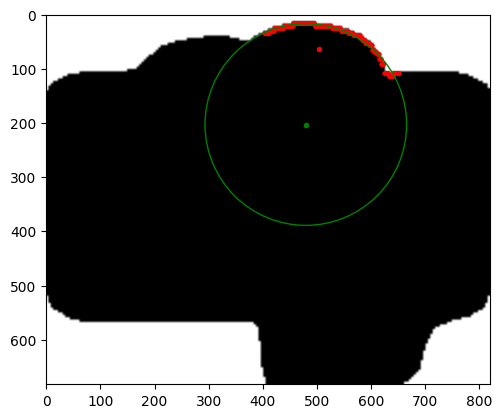

In [1]:
# 拟合并且保存图片
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.patches import Circle
import os
# from scipy.optimize import curve_fit

def circle(x, cx, cy, r):
    return np.sqrt(r**2 - (x - cx)**2) + cy

# 读取黑白图片
filename = 'p6-2.bmp'
folder_path = './resized_images/'
# os.path.join(output_path, 'fitted_'+filename)
image = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('./cropped/cropped_p2-1_0015.bmp', cv2.IMREAD_GRAYSCALE)
width, length = image.shape
print(length)

# 定义特定区域的边界框 [start_row:end_row, start_col:end_col]

start_row, end_row = 0, 250  # 请根据实际情况调整
start_col, end_col = 260, 420

scale_factor = 820/528

start_row = int(start_row * scale_factor)
end_row = int(end_row * scale_factor)
start_col = int(start_col * scale_factor)
end_col = int(end_col * scale_factor)

# 裁剪图像
cropped_image = image[start_row:end_row, start_col:end_col]

# 获取裁剪后图像的形状
rows, cols = cropped_image.shape

# 存储每列的第一个黑色点的坐标
first_black_pixels = []

# 遍历每一列
for col in range(cols):
    # 找到当前列中第一个黑色点的行坐标
    black_pixel_row = np.argmax(cropped_image[:, col] == 0)
    
    # 如果找到了黑色点，则记录坐标
    if black_pixel_row > 0:  # 0 表示未找到黑色点
        # 转换坐标为完整图像坐标
        full_image_row =width - (start_row + black_pixel_row)
        first_black_pixels.append((start_col + col, full_image_row))

# 将坐标转换为 NumPy 数组
first_black_pixels = np.array(first_black_pixels)
# print(first_black_pixels)

# 进行圆形拟合
p0 = [np.mean(first_black_pixels[:, 0]), np.mean(first_black_pixels[:, 1])-200, 200.0]  # 初始猜测值
# p0 = [150, 100, 100.0]  # 初始猜测值
params, covariance = curve_fit(circle, first_black_pixels[:, 0], first_black_pixels[:, 1], p0=p0)
fit_errors = np.sqrt(np.diag(covariance))

# 提取拟合结果
cx, cy, r = params

# 生成拟合曲线的 x 值范围
fit_x = np.linspace(min(first_black_pixels[:, 0]), max(first_black_pixels[:, 0]), 100)

# 计算拟合曲线的 y 值
fit_y = circle(fit_x, cx, cy, r)

# 显示图像
output_path = './fitted/'

output_filename = os.path.join(output_path, 'fitted_'+filename.replace('bmp','jpg'))

plt.imshow(image, cmap='gray')

# 在坐标轴上画出每列的第一个黑色点的位置
plt.scatter(first_black_pixels[:, 0], width-first_black_pixels[:, 1], color='red', s=5)
# 画出拟合圆
# plt.plot(fit_x, fit_y, color='blue')
circle_patch = Circle((cx, width-cy), r, color='green', fill=False)
plt.gca().add_patch(circle_patch)


scale_factor = 41 / length  # 将369像素映射到29mm

# 标记圆心位置
plt.scatter(cx, width-cy, color='green', marker='.')

p1= [2.8, 25]
p1_scaled=[0,0]
p1_scaled[0] = (-p1[0]+28)/scale_factor
p1_scaled[1] = width - (p1[1]+6)/scale_factor 
print( "焊接位置/mm：", p1[0], p1[1]) 

print(p1_scaled)
plt.scatter(p1_scaled[0], p1_scaled[1], color='red', marker='.')

# # 显示图像、黑色像素位置和拟合圆
# plt.axis('equal')
# plt.show()
plt.savefig(output_filename)
print("圆半径",r,"pix")


scaled_first_black_pixels = first_black_pixels * scale_factor
# p0_scaled = [175 * scale_factor, 60 * scale_factor, 150.0 * scale_factor]  # 初始猜测值
p0_scaled = [p * scale_factor for p in p0]
params_scaled, covariance_scaled = curve_fit(circle, scaled_first_black_pixels[:, 0], scaled_first_black_pixels[:, 1], p0=p0_scaled)

# 计算标准偏差作为拟合误差的估计
fit_errors_scaled = np.sqrt(np.diag(covariance_scaled))

print(f"Circle center (cx/pix, cy/pix): ({cx:.3f} ± {fit_errors[0]:.3f}, {580 - cy:.3f} ± {fit_errors[1]:.3f})")
print(f"Circle radius (r/pix): {r:.3f} ± {fit_errors[2]:.3f}")

print(f"Circle center (cx_scaled/mm, cy_scaled/mm): ({28-cx*scale_factor:.3f} ± {fit_errors_scaled[0]:.3f}, {cy*scale_factor-6:.3f} ± {fit_errors_scaled[1]:.3f})")
print(f"Circle radius (r_scaled/mm): {r*scale_factor:.3f} ± {fit_errors_scaled[2]:.3f}")

print(f"relative error: {100 * fit_errors_scaled[0]/(28-cx*scale_factor):.3f}, {100 * fit_errors_scaled[1]/(cy*scale_factor-6):.3f}, {100 * fit_errors_scaled[2]/(r*scale_factor):.3f}")


# cv2.imwrite(output_filename, image)

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.patches import Circle
# from scipy.optimize import curve_fit

def circle(x, cx, cy, r):
    return np.sqrt(r**2 - (x - cx)**2) + cy

# 读取黑白图片
image = cv2.imread('./ppt_2/p6-2_2.bmp', cv2.IMREAD_GRAYSCALE)
width, length = image.shape
print(width)

# 定义特定区域的边界框 [start_row:end_row, start_col:end_col]

start_row, end_row = 0, 250  # 请根据实际情况调整
start_col, end_col = 365, 640

# imgcrop = image.crop((start_row, start_col, end_row, end_col))
# plt.imshow(imgcrop)

# 裁剪图像
cropped_image = image[start_row:end_row, start_col:end_col]
plt.imshow(cropped_image)

AttributeError: 'NoneType' object has no attribute 'shape'

820
焊接位置/mm： 2.8 25
[503.99999999999994, 49.0]
圆半径 183.13600149130676 pix
Circle center (cx/pix, cy/pix): (480.138 ± 0.263, 99.206 ± 0.847)
Circle radius (r/pix): 183.136 ± 0.754
Circle center (cx_scaled/mm, cy_scaled/mm): (3.993 ± 0.013, 18.040 ± 0.042)
Circle radius (r_scaled/mm): 9.157 ± 0.038
relative error: 0.330, 0.235, 0.412


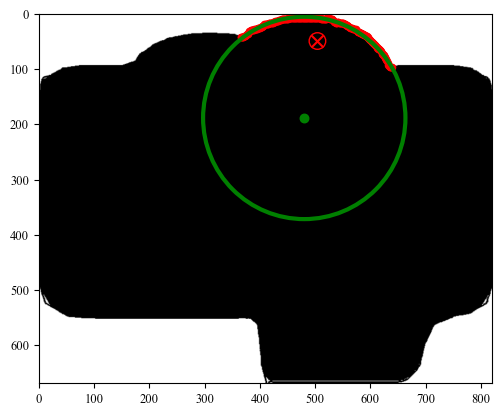

In [ ]:
# 拟合并且保存图片
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.patches import Circle
import os
# from scipy.optimize import curve_fit

def circle(x, cx, cy, r):
    return np.sqrt(r**2 - (x - cx)**2) + cy

# 读取黑白图片
filename = 'p6-2.bmp'
folder_path = './resized_images/'
# os.path.join(output_path, 'fitted_'+filename)
image = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
# image = cv2.imread('./cropped/cropped_p2-1_0015.bmp', cv2.IMREAD_GRAYSCALE)
width, length = image.shape
print(length)

# 定义特定区域的边界框 [start_row:end_row, start_col:end_col]
start_row, end_row = 0, 250  # 请根据实际情况调整
start_col, end_col = 365, 640

scale_factor = 1

start_row = int(start_row * scale_factor)
end_row = int(end_row * scale_factor)
start_col = int(start_col * scale_factor)
end_col = int(end_col * scale_factor)

# 裁剪图像
cropped_image = image[start_row:end_row, start_col:end_col]

# 获取裁剪后图像的形状
rows, cols = cropped_image.shape

# 存储每列的第一个黑色点的坐标
first_black_pixels = []

# 遍历每一列
for col in range(cols):
    # 找到当前列中第一个黑色点的行坐标
    black_pixel_row = np.argmax(cropped_image[:, col] == 0)
    
    # 如果找到了黑色点，则记录坐标
    if black_pixel_row > 0:  # 0 表示未找到黑色点
        # 转换坐标为完整图像坐标
        full_image_row =width - (start_row + black_pixel_row)
        first_black_pixels.append((start_col + col, full_image_row))

# 将坐标转换为 NumPy 数组
first_black_pixels = np.array(first_black_pixels)
# print(first_black_pixels)

# 进行圆形拟合
p0 = [np.mean(first_black_pixels[:, 0]), np.mean(first_black_pixels[:, 1])-200, 200.0]  # 初始猜测值
# p0 = [150, 100, 100.0]  # 初始猜测值
params, covariance = curve_fit(circle, first_black_pixels[:, 0], first_black_pixels[:, 1], p0=p0)
fit_errors = np.sqrt(np.diag(covariance))

# 提取拟合结果
cx, cy, r = params

# 生成拟合曲线的 x 值范围
fit_x = np.linspace(min(first_black_pixels[:, 0]), max(first_black_pixels[:, 0]), 100)

# 计算拟合曲线的 y 值
fit_y = circle(fit_x, cx, cy, r)

# 显示图像
output_path = './fitted/'

output_filename = os.path.join(output_path, 'fitted_'+filename.replace('bmp','jpg'))

plt.imshow(image, cmap='gray')

# 在坐标轴上画出每列的第一个黑色点的位置
plt.scatter(first_black_pixels[:, 0], width-first_black_pixels[:, 1], color='red', s=20)
# 画出拟合圆
# plt.plot(fit_x, fit_y, color='red')
# circle_patch = Circle((cx, width-cy), r, color='green', fill=False)
circle_patch = Circle((cx, width-cy), r, color='green', fill=False, linewidth=3)
plt.gca().add_patch(circle_patch)


scale_factor = 41 / length  # 将369像素映射到29mm

# 标记圆心位置
plt.scatter(cx, width-cy, color='green', marker='.', s=150)

p1= [2.8, 25]
p1_scaled=[0,0]
p1_scaled[0] = (-p1[0]+28)/scale_factor
p1_scaled[1] = width - (p1[1]+6)/scale_factor 
print( "焊接位置/mm：", p1[0], p1[1]) 

print(p1_scaled)
# plt.scatter(p1_scaled[0], p1_scaled[1], color='red', marker='.', s=100)
# plt.scatter(p1_scaled[0], p1_scaled[1], color='red', marker='o', s=100, edgecolors='black', linewidth=1.5)
circle_patch = Circle((p1_scaled[0], p1_scaled[1]), radius=15, color='red', fill=False)
plt.gca().add_patch(circle_patch)
plt.scatter(p1_scaled[0], p1_scaled[1], color='red', marker='x', s=75)
# plt.axis('off') 
# # 显示图像、黑色像素位置和拟合圆
# plt.axis('equal')
# plt.show()
plt.savefig(output_filename)
print("圆半径",r,"pix")


scaled_first_black_pixels = first_black_pixels * scale_factor
# p0_scaled = [175 * scale_factor, 60 * scale_factor, 150.0 * scale_factor]  # 初始猜测值
p0_scaled = [p * scale_factor for p in p0]
params_scaled, covariance_scaled = curve_fit(circle, scaled_first_black_pixels[:, 0], scaled_first_black_pixels[:, 1], p0=p0_scaled)

# 计算标准偏差作为拟合误差的估计
fit_errors_scaled = np.sqrt(np.diag(covariance_scaled))

print(f"Circle center (cx/pix, cy/pix): ({cx:.3f} ± {fit_errors[0]:.3f}, {580 - cy:.3f} ± {fit_errors[1]:.3f})")
print(f"Circle radius (r/pix): {r:.3f} ± {fit_errors[2]:.3f}")

print(f"Circle center (cx_scaled/mm, cy_scaled/mm): ({28-cx*scale_factor:.3f} ± {fit_errors_scaled[0]:.3f}, {cy*scale_factor-6:.3f} ± {fit_errors_scaled[1]:.3f})")
print(f"Circle radius (r_scaled/mm): {r*scale_factor:.3f} ± {fit_errors_scaled[2]:.3f}")

print(f"relative error: {100 * fit_errors_scaled[0]/(28-cx*scale_factor):.3f}, {100 * fit_errors_scaled[1]/(cy*scale_factor-6):.3f}, {100 * fit_errors_scaled[2]/(r*scale_factor):.3f}")


# cv2.imwrite(output_filename, image)

820
y_loss: 1.8535756009988826
r_squared: 0.9930207533846966


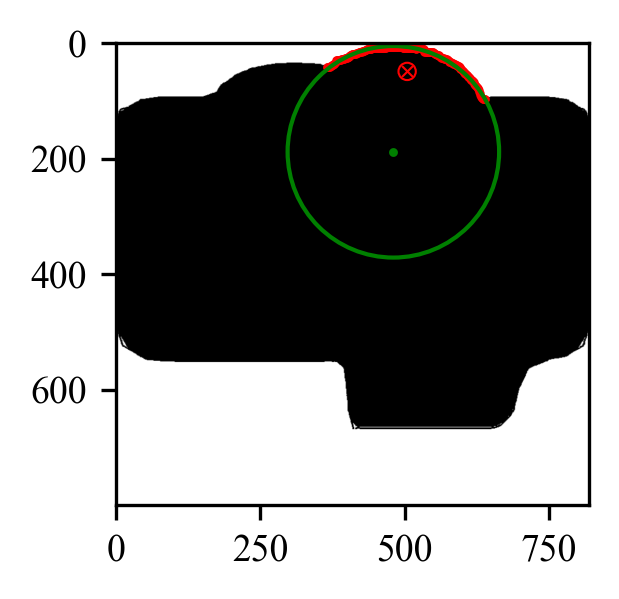

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')

plt.rcParams.update({'font.size': 9})
# plt.figure(figsize=(2.1, 2), dpi=300)
# plt.gca().set_aspect('equal', adjustable='box')
fig, axes = plt.subplots(figsize=(2.1, 2), dpi=300)



height, width = image.shape
print(width)  # 打印图像的宽度

new_height = height 

# 创建一个新的行，填充为255，长度为图像的宽度
new_row = np.ones((71, width)) * 255  

# 添加新的行到图像数组的顶部
# image = np.vstack((new_row, image))  

# 创建一个新的行，填充为255，长度为图像的宽度
new_row2 = np.ones((800 - height, width)) * 255  

# 添加新的行到图像数组的底部
image = np.vstack((image, new_row2))



plt.imshow(image, cmap='gray')

# 在坐标轴上画出每列的第一个黑色点的位置
plt.scatter(first_black_pixels[:, 0], new_height - first_black_pixels[:, 1], color='red', s=1)
# 画出拟合圆
# plt.plot(fit_x, fit_y, color='red')
# circle_patch = Circle((cx, width-cy), r, color='green', fill=False)
circle_patch = Circle((cx, new_height - cy), r, color='green', fill=False, linewidth=1)
plt.gca().add_patch(circle_patch)


# 画出拟合圆
# plt.plot(fit_x, fit_y, color='blue')
# p1_scaled[1] = p1_scaled[1] +71

circle_patch = Circle((p1_scaled[0], p1_scaled[1]), radius=15, color='red', fill=False, linewidth=0.5)
plt.gca().add_patch(circle_patch)

plt.scatter(p1_scaled[0], p1_scaled[1], color='red', marker='x', s=7, linewidth=0.5)


predicted_y = circle(first_black_pixels[:, 0], *params)

# 计算拟合误差
y_loss = np.sqrt(np.mean((first_black_pixels[:, 1] - predicted_y)**2))
print('y_loss:', y_loss)

r_squared = 1 - (np.sum((first_black_pixels[:, 1] - circle(first_black_pixels[:, 0], *params))**2) / np.sum((first_black_pixels[:, 1] - np.mean(first_black_pixels[:, 1]))**2))
print('r_squared:', r_squared)

# 标记圆心位置
plt.scatter(cx, new_height - cy, color='green', marker='.', s=5,)